In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from scipy import stats
import random

In [5]:
# Set seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

In [6]:
# Simple neural network with optional noise embeddings
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=64, num_classes=3, use_noise_embeddings=True, noise_dim=16):
        super(SimpleClassifier, self).__init__()
        self.use_noise_embeddings = use_noise_embeddings
        self.noise_dim = noise_dim

        # Main network
        if use_noise_embeddings:
            # Add noise embeddings to input dimension
            self.fc1 = nn.Linear(input_dim + noise_dim, hidden_dim)
        else:
            self.fc1 = nn.Linear(input_dim, hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        if self.use_noise_embeddings:
            # Add Gaussian noise embeddings
            batch_size = x.size(0)
            noise = torch.randn(batch_size, self.noise_dim, device=x.device) * 0.1
            x = torch.cat([x, noise], dim=1)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [7]:
# Generate synthetic dataset
def create_dataset(n_samples=1000, input_dim=100, num_classes=3):
    set_seeds(42)

    # Create synthetic data with some structure
    X = torch.randn(n_samples, input_dim)

    # Create labels with some correlation to input features
    weights = torch.randn(input_dim, num_classes)
    logits = X @ weights + torch.randn(n_samples, num_classes) * 0.5
    y = torch.argmax(logits, dim=1)

    return X, y

In [8]:
# Training function
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        val_acc = 100 * correct / total
        train_losses.append(total_loss / len(train_loader))
        val_accuracies.append(val_acc)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Loss={total_loss/len(train_loader):.4f}, Val Acc={val_acc:.2f}%')

    return train_losses, val_accuracies


In [9]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_predictions,
        'labels': all_labels
    }


In [10]:
# Run ablation study
def run_ablation_study():
    print("=== NOISE EMBEDDINGS ABLATION STUDY ===\n")

    # Create dataset
    X, y = create_dataset(n_samples=1000, input_dim=100, num_classes=3)

    # Split data
    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))
    test_size = len(X) - train_size - val_size

    train_X, train_y = X[:train_size], y[:train_size]
    val_X, val_y = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    test_X, test_y = X[train_size+val_size:], y[train_size+val_size:]

    # Create data loaders
    train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_X, val_y), batch_size=32, shuffle=False)
    test_loader = DataLoader(TensorDataset(test_X, test_y), batch_size=32, shuffle=False)

    # Store results
    results_with_noise = []
    results_without_noise = []

    print("Running 5 experiments WITH noise embeddings...")
    for run in range(5):
        set_seeds(42 + run)  # Different seed for each run
        model = SimpleClassifier(use_noise_embeddings=True)
        train_losses, val_accs = train_model(model, train_loader, val_loader, epochs=50)
        results = evaluate_model(model, test_loader)
        results_with_noise.append(results)
        print(f"Run {run+1}: Test Accuracy = {results['accuracy']:.4f}")

    print("\nRunning 5 experiments WITHOUT noise embeddings...")
    for run in range(5):
        set_seeds(42 + run)  # Same seeds for fair comparison
        model = SimpleClassifier(use_noise_embeddings=False)
        train_losses, val_accs = train_model(model, train_loader, val_loader, epochs=50)
        results = evaluate_model(model, test_loader)
        results_without_noise.append(results)
        print(f"Run {run+1}: Test Accuracy = {results['accuracy']:.4f}")

    return results_with_noise, results_without_noise, test_y


In [11]:
# Statistical analysis
def analyze_results(results_with_noise, results_without_noise):
    print("\n=== STATISTICAL ANALYSIS ===")

    # Extract metrics
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    for metric in metrics:
        with_noise = [r[metric] for r in results_with_noise]
        without_noise = [r[metric] for r in results_without_noise]

        # Calculate statistics
        mean_with = np.mean(with_noise)
        std_with = np.std(with_noise)
        mean_without = np.mean(without_noise)
        std_without = np.std(without_noise)

        # Perform t-test
        t_stat, p_value = stats.ttest_ind(with_noise, without_noise)

        print(f"\n{metric.upper()}:")
        print(f"  With noise:    {mean_with:.4f} ± {std_with:.4f}")
        print(f"  Without noise: {mean_without:.4f} ± {std_without:.4f}")
        print(f"  Difference:    {mean_with - mean_without:.4f}")
        print(f"  T-test p-value: {p_value:.4f}")
        print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")


In [12]:
# Visualization
def create_visualizations(results_with_noise, results_without_noise, test_y):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Performance comparison
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    with_noise_means = [np.mean([r[m] for r in results_with_noise]) for m in metrics]
    without_noise_means = [np.mean([r[m] for r in results_without_noise]) for m in metrics]
    with_noise_stds = [np.std([r[m] for r in results_with_noise]) for m in metrics]
    without_noise_stds = [np.std([r[m] for r in results_without_noise]) for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    axes[0,0].bar(x - width/2, with_noise_means, width, yerr=with_noise_stds,
                  label='With Noise', alpha=0.8, color='skyblue')
    axes[0,0].bar(x + width/2, without_noise_means, width, yerr=without_noise_stds,
                  label='Without Noise', alpha=0.8, color='lightcoral')
    axes[0,0].set_xlabel('Metrics')
    axes[0,0].set_ylabel('Score')
    axes[0,0].set_title('Performance Comparison')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(metrics)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Accuracy distribution
    acc_with = [r['accuracy'] for r in results_with_noise]
    acc_without = [r['accuracy'] for r in results_without_noise]

    axes[0,1].hist(acc_with, alpha=0.7, label='With Noise', bins=5, color='skyblue')
    axes[0,1].hist(acc_without, alpha=0.7, label='Without Noise', bins=5, color='lightcoral')
    axes[0,1].set_xlabel('Accuracy')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Accuracy Distribution Across Runs')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. Confusion matrix (last run with noise)
    cm_with = confusion_matrix(results_with_noise[-1]['labels'], results_with_noise[-1]['predictions'])
    sns.heatmap(cm_with, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
    axes[1,0].set_title('Confusion Matrix (With Noise)')
    axes[1,0].set_xlabel('Predicted')
    axes[1,0].set_ylabel('Actual')

    # 4. Confusion matrix (last run without noise)
    cm_without = confusion_matrix(results_without_noise[-1]['labels'], results_without_noise[-1]['predictions'])
    sns.heatmap(cm_without, annot=True, fmt='d', cmap='Reds', ax=axes[1,1])
    axes[1,1].set_title('Confusion Matrix (Without Noise)')
    axes[1,1].set_xlabel('Predicted')
    axes[1,1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()


In [13]:
# Error analysis
def perform_error_analysis(results_with_noise, results_without_noise, test_y):
    print("\n=== ERROR ANALYSIS ===")

    # Get predictions from last run of each condition
    pred_with = results_with_noise[-1]['predictions']
    pred_without = results_without_noise[-1]['predictions']
    true_labels = results_with_noise[-1]['labels']

    # Find where models disagree
    disagreement_mask = np.array(pred_with) != np.array(pred_without)
    disagreement_indices = np.where(disagreement_mask)[0]

    print(f"Models disagree on {len(disagreement_indices)} out of {len(true_labels)} samples ({len(disagreement_indices)/len(true_labels)*100:.1f}%)")

    if len(disagreement_indices) > 0:
        # Analyze disagreements
        correct_with_noise = np.array(pred_with)[disagreement_indices] == np.array(true_labels)[disagreement_indices]
        correct_without_noise = np.array(pred_without)[disagreement_indices] == np.array(true_labels)[disagreement_indices]

        print(f"Of disagreements:")
        print(f"  - Model with noise is correct: {np.sum(correct_with_noise)} times")
        print(f"  - Model without noise is correct: {np.sum(correct_without_noise)} times")
        print(f"  - Both are wrong: {np.sum(~correct_with_noise & ~correct_without_noise)} times")


=== NOISE EMBEDDINGS ABLATION STUDY ===

Running 5 experiments WITH noise embeddings...
Epoch 0: Loss=1.0910, Val Acc=44.00%
Epoch 10: Loss=0.0701, Val Acc=88.67%
Epoch 20: Loss=0.0298, Val Acc=86.67%
Epoch 30: Loss=0.0089, Val Acc=86.67%
Epoch 40: Loss=0.0056, Val Acc=86.00%
Run 1: Test Accuracy = 0.8267
Epoch 0: Loss=1.0886, Val Acc=52.00%
Epoch 10: Loss=0.0765, Val Acc=91.33%
Epoch 20: Loss=0.0213, Val Acc=88.67%
Epoch 30: Loss=0.0108, Val Acc=90.00%
Epoch 40: Loss=0.0108, Val Acc=86.00%
Run 2: Test Accuracy = 0.8067
Epoch 0: Loss=1.0866, Val Acc=46.00%
Epoch 10: Loss=0.0783, Val Acc=90.00%
Epoch 20: Loss=0.0270, Val Acc=89.33%
Epoch 30: Loss=0.0095, Val Acc=90.00%
Epoch 40: Loss=0.0044, Val Acc=87.33%
Run 3: Test Accuracy = 0.8267
Epoch 0: Loss=1.0866, Val Acc=54.00%
Epoch 10: Loss=0.0864, Val Acc=90.67%
Epoch 20: Loss=0.0180, Val Acc=90.00%
Epoch 30: Loss=0.0166, Val Acc=91.33%
Epoch 40: Loss=0.0071, Val Acc=88.67%
Run 4: Test Accuracy = 0.8133
Epoch 0: Loss=1.0818, Val Acc=44.00%

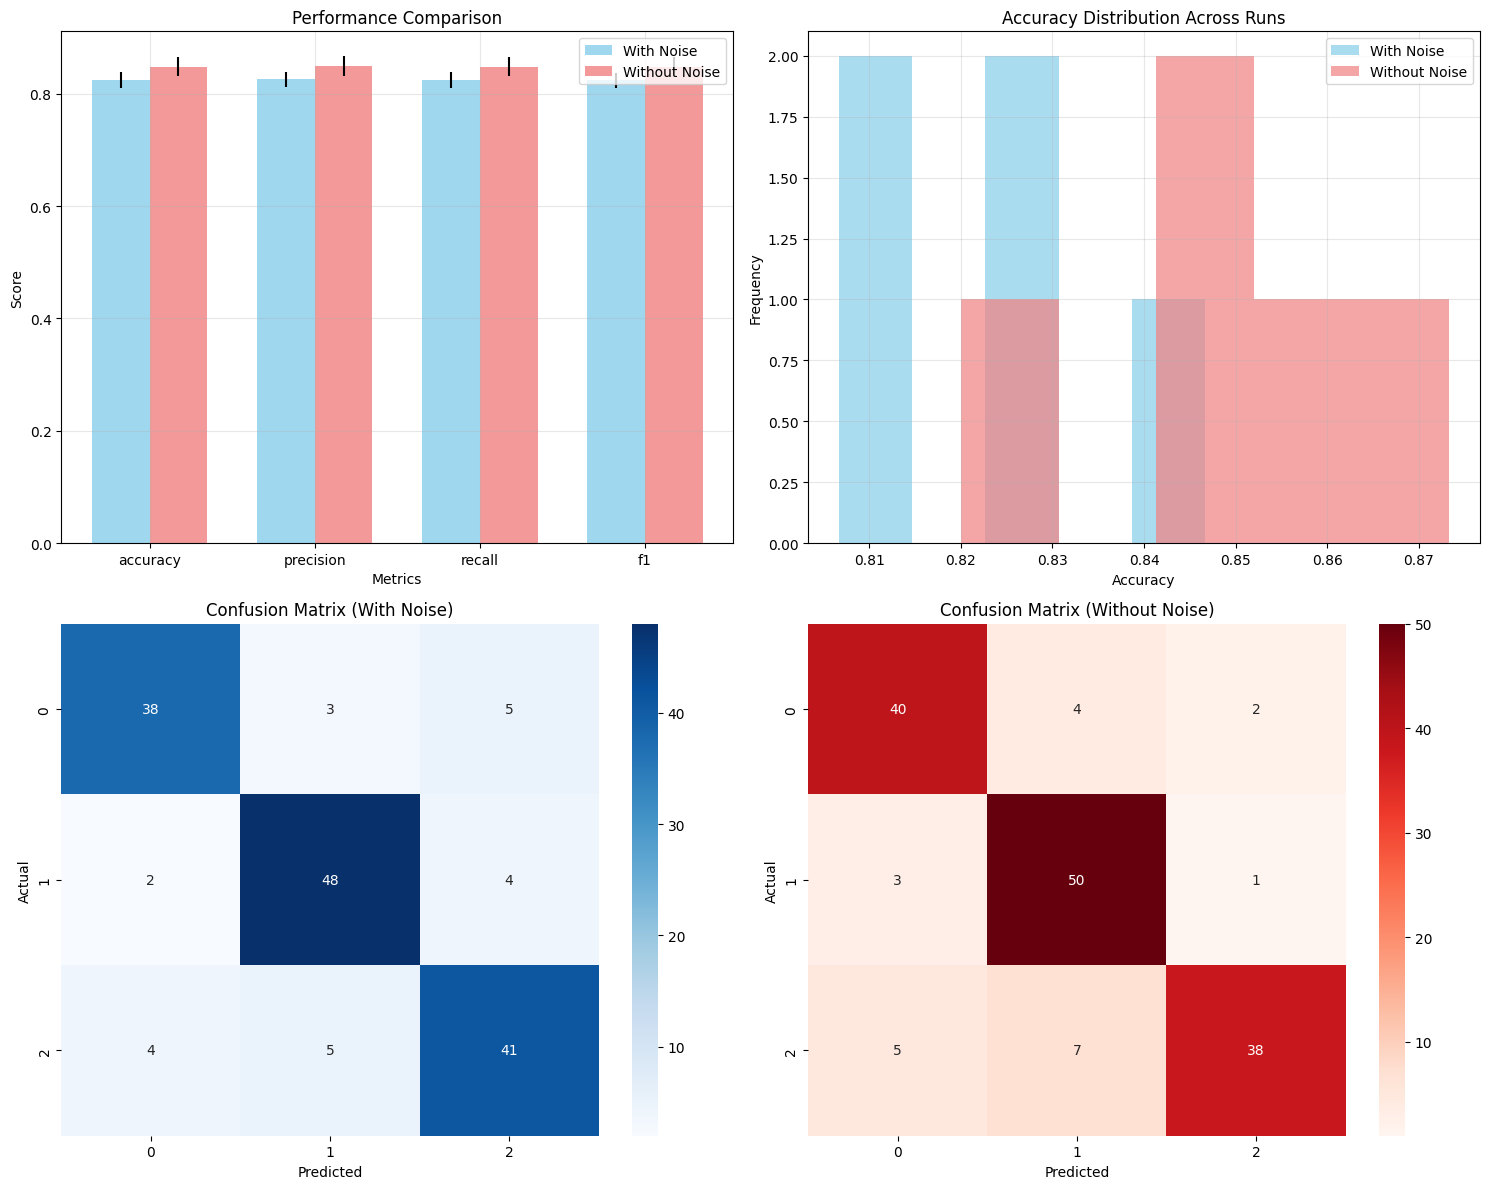


=== ERROR ANALYSIS ===
Models disagree on 16 out of 150 samples (10.7%)
Of disagreements:
  - Model with noise is correct: 7 times
  - Model without noise is correct: 8 times
  - Both are wrong: 1 times

=== CONCLUSION ===
✗ Noise embeddings appear to be a NET NEGATIVE for model performance
  Average decrease: 2.40 percentage points

Key findings:
- Models with noise embeddings: 0.8240 ± 0.0137
- Models without noise embeddings: 0.8480 ± 0.0171


In [14]:
# Main execution
def main():
    # Run the ablation study
    results_with_noise, results_without_noise, test_y = run_ablation_study()

    # Analyze results
    analyze_results(results_with_noise, results_without_noise)

    # Create visualizations
    create_visualizations(results_with_noise, results_without_noise, test_y)

    # Perform error analysis
    perform_error_analysis(results_with_noise, results_without_noise, test_y)

    # Conclusion
    print("\n=== CONCLUSION ===")
    acc_with_mean = np.mean([r['accuracy'] for r in results_with_noise])
    acc_without_mean = np.mean([r['accuracy'] for r in results_without_noise])

    if acc_with_mean > acc_without_mean:
        print("✓ Noise embeddings appear to be a NET POSITIVE for model performance")
        print(f"  Average improvement: {(acc_with_mean - acc_without_mean)*100:.2f} percentage points")
    else:
        print("✗ Noise embeddings appear to be a NET NEGATIVE for model performance")
        print(f"  Average decrease: {(acc_without_mean - acc_with_mean)*100:.2f} percentage points")

    print(f"\nKey findings:")
    print(f"- Models with noise embeddings: {acc_with_mean:.4f} ± {np.std([r['accuracy'] for r in results_with_noise]):.4f}")
    print(f"- Models without noise embeddings: {acc_without_mean:.4f} ± {np.std([r['accuracy'] for r in results_without_noise]):.4f}")

if __name__ == "__main__":
    main()